# PilotNet LIF Example

This tutorial demonstrates how to use __lava__ to perform inference on a PilotNet LIF on both CPU and Loihi 2 neurocore.

![PilotNet Inference](images/pilotnet_lif.PNG)

The network receives video input, recorded from a dashboard camera of a driving car (__Dataloader__). The data is encoded efficiently as the difference between individual frames (__Encoder__). The data passes through the PilotNet LIF, which was trained with __lava-dl__ and is built using its __Network Exchange__ module (netx.hdf5.Network), which automatically generates a Lava process from the training artifact. The network estimates the angle of the steering wheel of the car, is read from the output layer neuron's voltage state, decoded using proper scaling (__Decoder__) and sent to a visualization (__Monitor__) and logging system (__Logger__).

The PilotNet LIF network predicts the steerting angle every 16th timestep. The input is sent from the dataloader at the same frequency and the PilotNet LIF network resets it's internal state every 16th timestep to prcoess the new input frame.

The core of the tutorial is lava-dl's Network Exchange module, which is available as `lava.lib.dl.netx.{hdf5, blocks, utils}`.
* `hdf5` implements automatic network generation.
* `blocks` implements individual layer blocks.
* `utils` implements hdf5 reading utilities. 

In addition, it also demonstrates how different lava processes can be connected with each other for real time interaction between them even though the underlying processes can be run on various backends, including Loihi 2.

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi2SimCfg, Loihi2HwCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc import io
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import RefPort

from lava.lib.dl import netx
from dataset import PilotNetDataset
from utils import (
    PilotNetEncoder, PilotNetDecoder, VoltageReader, PilotNetMonitor,
    loihi2hw_exception_map, loihi2sim_exception_map
)


# Import modules for Loihi2 execution

Check if Loihi2 compiker is available and import related modules.

In [2]:
from lava.utils.system import Loihi2
Loihi2.preferred_partition = 'oheogulch'
loihi2_is_available = Loihi2.is_loihi2_available

if loihi2_is_available:
    print(f'Running on {Loihi2.partition}')
    compression = io.encoder.Compression.DELTA_SPARSE_8
    from lava.proc import embedded_io as eio
    from lava.proc.embedded_io.state import Read as VoltageReader
else:
    print("Loihi2 compiler is not available in this system. "
          "This tutorial will execute on CPU backend.")
    compression = io.encoder.Compression.DENSE


Running on oheogulch


## Create network block

PilotNet LIF is described by the hdf5 file inference `network.net`.

A network block can be created by simply instantiating `netx.hdf5.Network` with the path of the desired hdf5 network description file.
* The input layer is accessible as `net.in_layer`.
* The output layer is accessible as `net.out_layer`.
* All the constituent layers are accessible as as a list: `net.layers`.

The PilotNet LIF needs to be reset for every input sample. The reset needs to be orchestrated at different time steps for each layer of the network for fastest possible throughput. `netx.hdf5.Network` features pipelined orchestration of layer reset where each subsequent layer is reset a time step later than it's input. 

![PilotNet Inference](images/pilotnet_lif_network.PNG)

In [3]:
# The input spike loads to dataloader at t=0
# Gets transmitted through the embedded processor at t=1
# and appears at the input layer at t=2
net = netx.hdf5.Network(net_config='network.net',
                        reset_interval=16,
                        reset_offset=3)
print(net)


|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Input     |  200|   66|    3|     |     |     |     |     |False|
|Conv      |   99|   32|   24| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   49|   15|   36| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   24|    7|   48| 3, 3| 2, 2| 0, 0| 1, 1|    1|False|
|Conv      |   22|    4|   64| 3, 3| 1, 2| 0, 1| 1, 1|    1|False|
|Conv      |   20|    2|   64| 3, 3| 1, 1| 0, 0| 1, 1|    1|False|
|Dense     |    1|    1|  100|     |     |     |     |     |False|
|Dense     |    1|    1|   50|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|
|Dense     |    1|    1|    1|     |     |     |     |     |False|


In [4]:
print(f'There are {len(net)} layers in network:')

for l in net.layers:
    print(f'{l.__class__.__name__:5s} : {l.name:10s}, shape : {l.shape}')


There are 10 layers in network:
Input : Process_1 , shape : (200, 66, 3)
Conv  : Process_3 , shape : (99, 32, 24)
Conv  : Process_6 , shape : (49, 15, 36)
Conv  : Process_9 , shape : (24, 7, 48)
Conv  : Process_12, shape : (22, 4, 64)
Conv  : Process_15, shape : (20, 2, 64)
Dense : Process_18, shape : (100,)
Dense : Process_21, shape : (50,)
Dense : Process_24, shape : (10,)
Dense : Process_27, shape : (1,)


## Set execution parameters
Configure number of samples, execution timesteps, and readout offset.

In [5]:
num_samples = 201
steps_per_sample = net.reset_interval
readout_offset = len(net) + 2
num_steps = num_samples * steps_per_sample + 1


## Create Dataset instance
Typically the user would write it or provide it.

In [6]:
full_set = PilotNetDataset(
    path='../data',
    transform=net.in_layer.transform,  # input transform
    visualize=True,  # visualize ensures the images are returned in sequence
    sample_offset=10550,
)
train_set = PilotNetDataset(
    path='../data',
    transform=net.in_layer.transform,  # input transform
    train=True,
)
test_set = PilotNetDataset(
    path='../data',
    transform=net.in_layer.transform,  # input transform
    train=False,
)


## Create Dataloader
The dataloader process reads data from the dataset objects and sends out the input frame and ground truth as spikes. The dataloader injects new input sample every `steps_per_sample`.

![PilotNet Inference](images/pilotnet_lif_dataloader.PNG)

In [7]:
dataloader = io.dataloader.SpikeDataloader(dataset=full_set,
                                           interval=steps_per_sample)


## Configure the input layer for graded spike input

The PilotNet LIF network's input layer does bias integration. Bias input is a slow process compared to graded spike input. Therefore, we tweak the input layer of PilotNet LIF to receive graded spike and integrate it on neuron's current (u) state to achieve effective bias input. 

In [8]:
net.in_layer.neuron.du.init = -1  # Make current state persistent


## Create Input Encoder

The input encoder process does frame difference of subsequent frames to sparsify the input to the network.

For Loihi execution, it additionally compresses and sends the input data to the Loihi 2 chip.

![PilotNet Inference](images/pilotnet_lif_encoder.PNG)

In [9]:
input_encoder = PilotNetEncoder(shape=net.in_layer.shape,
                                interval=steps_per_sample,
                                offset=1,
                                compression=compression)


## Create Output Decoder

The output of PilotNet LIF network is the output layer neuron's voltage. We use a `VoltageReader` to read the neuron voltage
and scale the input appropriately using `AffineTransformer`.

For Loihi execution, `VoltageReader` additionally communicates the read values from the Loihi 2 chip.

![PilotNet Inference](images/pilotnet_lif_decoder.PNG)

In [10]:
output_adapter = VoltageReader(shape=net.out.shape,
                               interval=steps_per_sample,
                               offset=len(net) + 1)
output_decoder = PilotNetDecoder(shape=net.out.shape,
                                 weight=1 / steps_per_sample / 32 / 64,
                                 interval=steps_per_sample,
                                 offset=len(net) + 2)


## Create Monitor and Dataloggers

Monitor is a lava process that visualizes the PilotNet network prediction in real-time. In addition, datalogger processes store the network predictions and ground truths.

![PilotNet Inference](images/pilotnet_lif_monitors.PNG)

In [11]:
monitor = PilotNetMonitor(shape=net.inp.shape,
                          transform=net.in_layer.transform,
                          interval=steps_per_sample)
gt_logger = io.sink.RingBuffer(shape=(1,), buffer=num_steps)
output_logger = io.sink.RingBuffer(shape=net.out.shape, buffer=num_steps)


# Connect the processes

![PilotNet Inference](images/pilotnet_lif.PNG)

In [12]:
dataloader.ground_truth.connect(gt_logger.a_in)
dataloader.s_out.connect(input_encoder.inp)
input_encoder.out.connect(net.in_layer.neuron.a_in)

output_adapter.connect_var(net.out_layer.neuron.v)
output_adapter.out.connect(output_decoder.inp)
output_decoder.out.connect(output_logger.a_in)

dataloader.s_out.connect(monitor.frame_in)
dataloader.ground_truth.connect(monitor.gt_in)
output_decoder.out.connect(monitor.output_in)


## Run the network

Switching between Loihi 2 hardware and CPU simulation is as simple as changing the run configuration settings.

![PilotNet Inference](images/pilotnet_lif_backends.PNG)

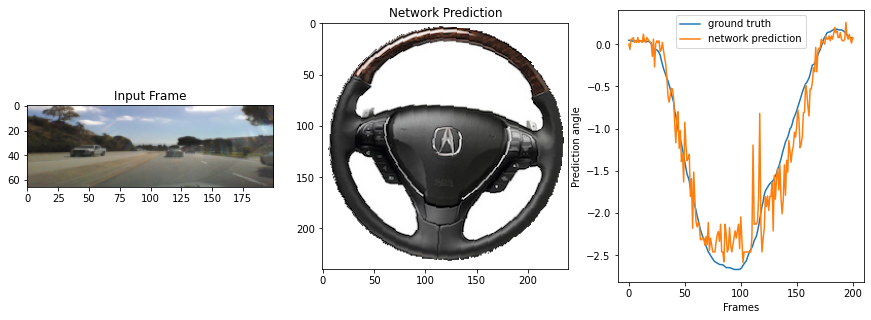

In [13]:
if loihi2_is_available:
    run_config = Loihi2HwCfg(exception_proc_model_map=loihi2hw_exception_map)
else:
    run_config = Loihi2SimCfg(select_tag='fixed_pt',
                              exception_proc_model_map=loihi2sim_exception_map)
net.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
output = output_logger.data.get().flatten()
gts = gt_logger.data.get().flatten()[::steps_per_sample]
net.stop()
result = output[readout_offset::steps_per_sample]


## Evaluate Results
Plot and compare the results with the dataset ground truth.

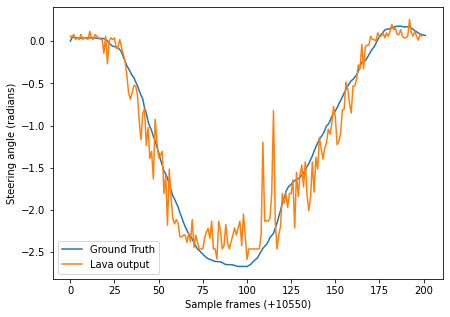

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(np.array(gts), label='Ground Truth')
plt.plot(result[1:].flatten(), label='Lava output')
plt.xlabel(f'Sample frames (+10550)')
plt.ylabel('Steering angle (radians)')
plt.legend()
